At first , resnet model have been trained( before handling class imbalance and after handling class imbalance. Then various models have been loaded and tested on kaggle data and our data

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
         #print(os.path.join(dirname, filename))
            pass

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [13]:


import numpy as np
import pandas as pd
import os
import cv2
from random import shuffle
import scipy
from tqdm import tqdm  
import skimage
from skimage.transform import resize

import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import UpSampling2D
from keras.layers import Activation
from keras.layers import MaxPool2D
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Lambda

from keras.layers import Input
from keras.layers import Dense
from keras.layers import AveragePooling2D
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.models import Model
from keras.regularizers import l2

from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import keras

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix



In [14]:


os.listdir("../input/chest-xray-pneumonia/chest_xray/chest_xray")



['.DS_Store', 'val', 'test', 'train']

In [15]:
TRAIN_DIR = "../input/chest-xray-pneumonia/chest_xray/chest_xray/train/"
VAL_DIR = "../input/chest-xray-pneumonia/chest_xray/chest_xray/val/"
TEST_DIR =  "../input/chest-xray-pneumonia/chest_xray/chest_xray/test/"

In [16]:
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions

In [17]:
img_height = 224
img_width = 224

nb_train_samples = 5216
nb_validation_samples = 16
nb_test_samples=624
epochs = 40
batch_size = 16

In [ ]:
from sklearn.utils import class_weight

def get_weight_dict(y_train):
    class_weights_current = dict(zip(np.unique(y_train), class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train))) 
    return class_weights_current


# resnet 101 architecture


In [7]:
# working
from keras import models
from keras import layers
from keras.applications import ResNet101
from keras import optimizers
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

model = models.Sequential()
model.add(ResNet101(include_top=False, pooling='avg', weights='imagenet'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))

model.layers[0].trainable = False

es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)



171450368/171446536 [==============================] - 1s 0us/step


In [8]:
##model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
image_size = 224
STEPS = nb_train_samples / batch_size
## Specify the values for all arguments to data_generator_with_aug.
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                             horizontal_flip = True,
                                             width_shift_range = 0.2,
                                             height_shift_range = 0.2,
                                             shear_range = 0.2,
                                             zoom_range = 0.2
                                            )
            
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input            
                                          )

train_generator = data_generator_with_aug.flow_from_directory(
       directory = TRAIN_DIR,
       target_size = (image_size, image_size),
       batch_size = batch_size,
       class_mode = 'categorical')

validation_generator = data_generator_no_aug.flow_from_directory(
       directory = VAL_DIR,
       target_size = (image_size, image_size),
       class_mode = 'categorical')

test_generator = data_generator_no_aug.flow_from_directory(
       directory = TEST_DIR,
       target_size = (image_size, image_size),
       batch_size = batch_size,
       shuffle = False,
       class_mode = 'categorical')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


history=model.fit_generator(train_generator,
                            epochs=20,
                            validation_data=validation_generator,
                            steps_per_epoch=nb_train_samples//batch_size,
                            validation_steps=nb_validation_samples // batch_size)

Our Data

In [19]:
TEST_DIR2 =  "../input/"
batch_size_test = 1
nb_test_samples2 = 139
test_datagen2 = ImageDataGenerator(rescale=1. / 255)
test_generator2 = test_datagen2.flow_from_directory(
    TEST_DIR2,
    classes=['pneumonia-test'],
    # don't generate labels
    class_mode=None,
    # don't shuffle
    shuffle=False,
    target_size=(img_width, img_height),
    batch_size=batch_size_test,)

Found 139 images belonging to 1 classes.


In [ ]:
# class_weight_dict = get_weight_dict(train_generator.classes)  
# class_weight_dict

In [11]:
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

In [ ]:
   model.fit_generator(
          train_generator, # specify where model gets training data
          epochs = 15,
          steps_per_epoch=STEPS,
          validation_data=validation_generator) #we have to use dictionary, not array
    #     class_weight=class_weight_dict



# using resnet 101 after handling  class imbalance with weighted loss function 

In [ ]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = 1 - positive_frequencies

    ### END CODE HERE ###
    return positive_frequencies, negative_frequencies

In [ ]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

In [ ]:
freq_pos_arr = np.asarray((freq_pos,freq_neg ))
freq_neg_arr = np.asarray((freq_neg, freq_pos ))

In [ ]:
#freq_neg = np.atleast_1d(freq_neg)

In [ ]:
pos_weights = freq_neg_arr
neg_weights = freq_pos_arr

In [ ]:
pos_weights

In [ ]:
from keras import backend as K
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Tensor): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        
        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class
            loss_pos = -1 * K.mean(pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * K.mean(neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg
        
        return loss
    
        ### END CODE HERE ###
    return weighted_loss

In [ ]:
#for single class 
def get_weighted_loss2(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Tensor): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        
        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

          # for each class, add average weighted loss for that class
        loss_pos = -1 * np.sum(pos_weights * y_true[:] * K.log(y_pred[:] + epsilon))
        loss_neg = -1 * np.sum(neg_weights * (1 - y_true[:]) * K.log(1 - y_pred[:] + epsilon))
        loss += loss_pos + loss_neg
        
        return loss
    
        ### END CODE HERE ###
    return weighted_loss

In [ ]:
opt = RMSprop(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss=get_weighted_loss2(pos_weights, neg_weights), metrics=['accuracy'],optimizer=opt)

In [ ]:
history=model.fit_generator(train_generator,
                            epochs=epochs,
                            validation_data=validation_generator,
                            steps_per_epoch=nb_train_samples//batch_size,
                            validation_steps=nb_validation_samples // batch_size)

# residual attention network architecture

In [ ]:
def residual_block(input, input_channels=None, output_channels=None, kernel_size=(3, 3), stride=1, blockName=None):

    if output_channels is None:
        output_channels = input.get_shape()[-1].value
    if input_channels is None:
        input_channels = output_channels // 4

    strides = (stride, stride)

#     x = BatchNormalization()(input)
#     x = Activation('relu')(x)
#     x = Conv2D(input_channels, (1, 1))(x)
 
    x = BatchNormalization()(input)
    x = Activation('relu')(x)
    if blockName is not None:
        blockName = blockName + 'conv1'
    x = Conv2D(input_channels, kernel_size, padding='same', strides=stride, name=blockName )(x)
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if blockName is not None:
        blockName = blockName + 'conv2'
    x = Conv2D(output_channels, (1, 1), padding='same', name=blockName )(x)

    if input_channels != output_channels or stride != 1:
        if blockName is not None:
            blockName = blockName + 'conv3'
        input = Conv2D(output_channels, (1, 1), padding='same', strides=strides, name=blockName )(input)

    x = Add()([x, input])
    return xdef residual_block(input, input_channels=None, output_channels=None, kernel_size=(3, 3), stride=1, blockName=None):

    if output_channels is None:
        output_channels = input.get_shape()[-1].value
    if input_channels is None:
        input_channels = output_channels // 4

    strides = (stride, stride)

#     x = BatchNormalization()(input)
#     x = Activation('relu')(x)
#     x = Conv2D(input_channels, (1, 1))(x)
 
    x = BatchNormalization()(input)
    x = Activation('relu')(x)
    if blockName is not None:
        blockName = blockName + 'conv1'
    x = Conv2D(input_channels, kernel_size, padding='same', strides=stride, name=blockName )(x)
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if blockName is not None:
        blockName = blockName + 'conv2'
    x = Conv2D(output_channels, (1, 1), padding='same', name=blockName )(x)

    if input_channels != output_channels or stride != 1:
        if blockName is not None:
            blockName = blockName + 'conv3'
        input = Conv2D(output_channels, (1, 1), padding='same', strides=strides, name=blockName )(input)

    x = Add()([x, input])
    return x

In [ ]:
def attention_block(input, input_channels=None, output_channels=None, encoder_depth=1):

    p = 1
    t = 2
    r = 1

    if input_channels is None:
        input_channels = input.get_shape()[-1].value
    if output_channels is None:
        output_channels = input_channels

    # First Residual Block
    for i in range(p):
        input = residual_block(input)

    # Trunc Branch
    output_trunk = input
    for i in range(t):
        output_trunk = residual_block(output_trunk)

    # Soft Mask Branch

    ## encoder
    ### first down sampling
    output_soft_mask = MaxPool2D(padding='same')(input)  # 32x32
    for i in range(r):
        output_soft_mask = residual_block(output_soft_mask)

    skip_connections = []
    for i in range(encoder_depth - 1):

        ## skip connections
        output_skip_connection = residual_block(output_soft_mask)
        skip_connections.append(output_skip_connection)
        # print ('skip shape:', output_skip_connection.get_shape())

        ## down sampling
        output_soft_mask = MaxPool2D(padding='same')(output_soft_mask)
        for _ in range(r):
            output_soft_mask = residual_block(output_soft_mask)

            ## decoder
    skip_connections = list(reversed(skip_connections))
    for i in range(encoder_depth - 1):
        ## upsampling
        for _ in range(r):
            output_soft_mask = residual_block(output_soft_mask)
        output_soft_mask = UpSampling2D()(output_soft_mask)
        ## skip connections
        output_soft_mask = Add()([output_soft_mask, skip_connections[i]])

    ### last upsampling
    for i in range(r):
        output_soft_mask = residual_block(output_soft_mask)
    output_soft_mask = UpSampling2D()(output_soft_mask)

    ## Output
    output_soft_mask = Conv2D(input_channels, (1, 1))(output_soft_mask)
    output_soft_mask = Conv2D(input_channels, (1, 1))(output_soft_mask)
    output_soft_mask = Activation('sigmoid')(output_soft_mask)

    # Attention: (1 + output_soft_mask) * output_trunk
    output = Lambda(lambda x: x + 1)(output_soft_mask)
    output = Multiply()([output, output_trunk])  #

    # Last Residual Block
    for i in range(p):
        output = residual_block(output)

    return output

In [ ]:
def AttentionResNet56(shape=(224, 224, 3), n_channels=64, n_classes=100,
                      dropout=0, regularization=0.01):

    regularizer = l2(regularization)

    input_ = Input(shape=shape)
    #x = Conv2D(n_channels, (7, 7), strides=(2, 2), padding='same')(input_) # 112x112
    x = Conv2D(n_channels, (3, 3), strides=(1, 1), padding='same')(input_) # 224x224
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)  # 56x56 ##same output 224

    x = residual_block(x, output_channels=n_channels * 4,stride=2, blockName = 'resblock1')  # 56x56  ##112
    x = attention_block(x, encoder_depth=2)  # bottleneck 7x7                                           ##112

    x = residual_block(x, output_channels=n_channels * 8, stride=2, blockName = 'resblock2')  # 28x28  ##56
    x = attention_block(x, encoder_depth=1)  # bottleneck 7x7                                           ##56
    
    x = residual_block(x, output_channels=n_channels * 8, stride=2, blockName = 'resblock3')  # 28x28   ##28
    x = attention_block(x, encoder_depth=1)  # bottleneck 7x7  ##28
    
    x = residual_block(x, output_channels=n_channels * 8, stride=2, blockName = 'resblock4')  # 28x28   ##14
    x = attention_block(x, encoder_depth=1)  # bottleneck 7x7  ##14

    x = residual_block(x, output_channels=n_channels * 16, stride=2, blockName = 'resblock5')  # 7x7
    input_channels_same = x.get_shape()[-1].value
    
    x = residual_block(x, input_channels = input_channels_same,  output_channels=input_channels_same, stride=1, blockName = 'resblock6')  # 7x7
    x = residual_block(x,input_channels = input_channels_same,  output_channels=input_channels_same, stride=1, blockName = 'resblock7')  # 7x7

    pool_size = (x.get_shape()[1].value, x.get_shape()[2].value)
    x = AveragePooling2D(pool_size=pool_size, strides=(1, 1))(x)
    x = Flatten()(x)
    x = Dropout(dropout)(x)
    x = Dense(256, kernel_regularizer=regularizer, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(16, kernel_regularizer=regularizer, activation='relu')(x)
    x = Dropout(dropout)(x)
    output = Dense(n_classes, kernel_regularizer=regularizer, activation='softmax')(x)

    model = Model(input_, output)
    return model

In [ ]:
model = AttentionResNet56(n_classes=2,dropout=.25)

In [ ]:
model.summary()

In [ ]:
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

opt = RMSprop(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

In [ ]:
history=model.fit_generator(train_generator,
                            epochs=epochs,
                            validation_data=validation_generator,
                            steps_per_epoch=nb_train_samples//batch_size,
                            validation_steps=nb_validation_samples // batch_size)

loading the trained model

In [ ]:
from keras.models import load_model
model_resnet101_balanced = load_model('../input/resnet101-balanced/pneumonia_resnet101_balanced.h5')



In [ ]:
# Evaluate the model
scores = model_resnet101_balanced.evaluate_generator(test_generator, workers = 1,steps=np.ceil(nb_test_samples/batch_size))



accuracy: 82.69%  with epoch 6

Other information given below

In [ ]:
#data = list(zip(test_generator2.filenames, preds2))

In [ ]:
import pandas as pd

In [ ]:
#df = pd.DataFrame(data, columns = ['fileName', 'output'])

All predictions are close to 50%

In [ ]:
#preds2 = np.argmax(preds2, axis=-1)

In [ ]:
#df2 = pd.DataFrame(list(zip(test_generator2.filenames, preds2)), columns = ['fileName', 'output'])

# **** Loading our models

# Load lung opacity model
 

In [21]:
from keras.models import load_model
model_opacity = load_model('../input/lung-opacity-rsna/full_model.h5')


In [22]:
pred_opacity = model_opacity.predict_generator(test_generator, workers = 1,steps=np.ceil(nb_test_samples/batch_size))

In [23]:
pred_opacity

array([[7.2933239e-04, 2.0666631e-02, 9.7860396e-01],
       [1.6990927e-05, 1.2020993e-03, 9.9878091e-01],
       [2.5262765e-04, 3.6961215e-03, 9.9605125e-01],
       ...,
       [6.1439639e-01, 2.9104066e-01, 9.4562970e-02],
       [2.9062989e-01, 2.0488521e-01, 5.0448489e-01],
       [4.2387953e-01, 5.5395877e-01, 2.2161622e-02]], dtype=float32)

In [24]:
pred_opacity = np.argmax(pred_opacity, axis=-1)

In [25]:
pred_opacity

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 2,
       2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 0, 2,
       0, 0, 2, 2, 0, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 0, 1, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 0, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2,
       1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2,
       1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 2, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 2, 1, 0, 0, 1,
       2, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,

In [26]:
pred3 = np.array([0 if xi == 2 else xi for xi in pred_opacity ])   # lung opacity = 1, no lung opacity/not normal  = 0,  normal = 2

In [27]:
pred3

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,

In [28]:
# Original labels
orig_test_labels = test_generator.classes[test_generator.index_array]  ##changed

print(orig_test_labels.shape)
print(pred3.shape)


(624,)
(624,)


<Figure size 432x288 with 0 Axes>

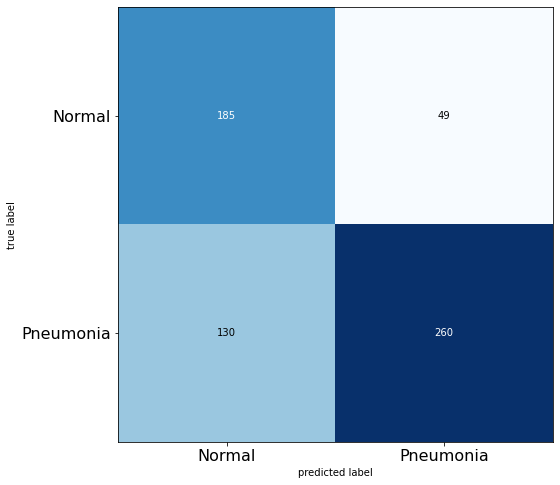

In [29]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, pred3)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show();

on our data

In [30]:
test_generator2.reset()
preds2 = model.predict_generator(test_generator2, workers = 1,steps=np.ceil(nb_test_samples2/batch_size_test)) #changed worker to 0



In [31]:
preds2

array([[0.5781767 , 0.42182332],
       [0.562483  , 0.43751702],
       [0.57032925, 0.42967078],
       [0.5788067 , 0.4211933 ],
       [0.5673476 , 0.4326524 ],
       [0.57002294, 0.4299771 ],
       [0.5749795 , 0.42502052],
       [0.579146  , 0.42085394],
       [0.57391196, 0.42608804],
       [0.57982403, 0.42017597],
       [0.5803478 , 0.41965225],
       [0.59828675, 0.40171325],
       [0.5820181 , 0.41798195],
       [0.56641877, 0.43358123],
       [0.58240384, 0.41759613],
       [0.57752526, 0.42247474],
       [0.5608339 , 0.43916607],
       [0.558886  , 0.44111398],
       [0.58177775, 0.41822222],
       [0.54869187, 0.45130807],
       [0.5697893 , 0.43021074],
       [0.581726  , 0.41827393],
       [0.57398427, 0.42601568],
       [0.5722375 , 0.42776254],
       [0.57367647, 0.4263235 ],
       [0.59085   , 0.40915006],
       [0.5720611 , 0.42793894],
       [0.5689699 , 0.4310301 ],
       [0.56324506, 0.4367549 ],
       [0.5867548 , 0.41324523],
       [0.

In [32]:
preds2 = np.argmax(preds2, axis=-1)

In [33]:
preds2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [34]:
##preds2 = np.array([0 if xi == 2 else xi for xi in pred2 ])

Loading other models

In [11]:
from keras.models import load_model
def prediction_report(model_path, test_generator, test_samples, batch_size):
    model = load_model(model_path)
    pred = model.predict_generator(test_generator, workers = 1,steps=np.ceil(nb_test_samples/batch_size))
    print("Prediction in probability:")
    print(pred)
    preds2 = np.argmax(pred, axis=-1)
    print("Prediction in class:")
    print(preds2)
    orig_test_labels = test_generator.classes[test_generator.index_array]
    # Get the confusion matrix
    cm  = confusion_matrix(orig_test_labels, preds2)
    plt.figure()
    plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
    plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
    plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
    plt.show();
    
    

using resnet 101 without handling class imbalance

on kaggle dataset

Prediction in probability:
[[9.25131321e-01 7.48686567e-02]
 [9.87531126e-01 1.24688679e-02]
 [9.86941516e-01 1.30585255e-02]
 ...
 [5.55036939e-04 9.99444902e-01]
 [1.64218228e-02 9.83578205e-01]
 [2.71533787e-01 7.28466272e-01]]
Prediction in class:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 

<Figure size 432x288 with 0 Axes>

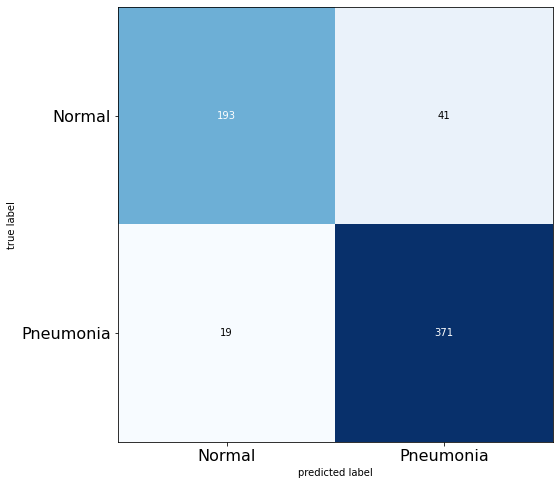

In [14]:
prediction_report("../input/resnet101-chest-x-ray/pneumonia_resnet101.h5", test_generator, test_samples=624 , batch_size = 16 )

on our data

Prediction in probability:
[[0.07023151 0.92976844]
 [0.06680509 0.93319494]
 [0.07057492 0.9294251 ]
 [0.07126083 0.9287392 ]
 [0.06982812 0.93017185]
 [0.06751054 0.93248945]
 [0.06650164 0.9334984 ]
 [0.07441065 0.9255894 ]
 [0.06862552 0.9313745 ]
 [0.07234456 0.9276554 ]
 [0.06755826 0.9324418 ]
 [0.07155488 0.9284451 ]
 [0.06678507 0.9332149 ]
 [0.07008208 0.9299179 ]
 [0.06977177 0.9302282 ]
 [0.06352364 0.9364764 ]
 [0.0679339  0.9320661 ]
 [0.06421091 0.9357891 ]
 [0.06427465 0.93572533]
 [0.06073546 0.93926454]
 [0.06781945 0.9321806 ]
 [0.07290575 0.9270942 ]
 [0.07193294 0.9280671 ]
 [0.06690565 0.9330944 ]
 [0.06636672 0.93363327]
 [0.06924149 0.9307585 ]
 [0.07102909 0.9289709 ]
 [0.0655661  0.9344339 ]
 [0.06804736 0.9319526 ]
 [0.06782214 0.93217784]
 [0.07098175 0.9290182 ]
 [0.07007343 0.9299266 ]
 [0.07366613 0.92633384]
 [0.07222744 0.9277726 ]
 [0.06758182 0.93241817]
 [0.06801058 0.9319894 ]
 [0.07269277 0.92730725]
 [0.07232041 0.92767966]
 [0.07267006 0.92732996

/opt/conda/lib/python3.7/site-packages/mlxtend/plotting/plot_confusion_matrix.py:66: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


<Figure size 432x288 with 0 Axes>

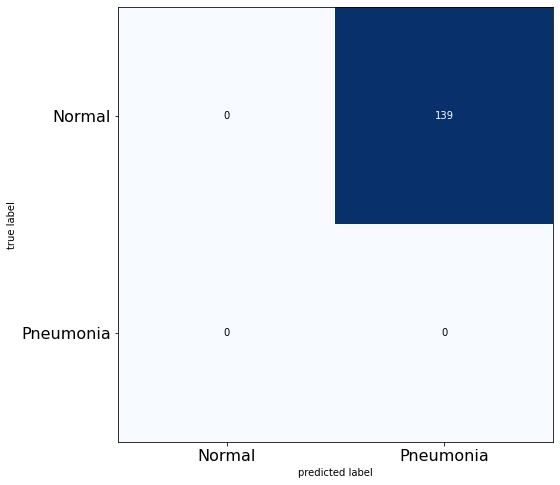

In [15]:
prediction_report("../input/resnet101-chest-x-ray/pneumonia_resnet101.h5", test_generator2, test_samples=139 , batch_size = 1 )

using resnet 101 after handling class imbalance

on kaggle test data

Prediction in probability:
[[9.9615932e-01 3.8406495e-03]
 [9.9873322e-01 1.2668215e-03]
 [9.9937075e-01 6.2923151e-04]
 ...
 [7.8188004e-03 9.9218118e-01]
 [1.6602220e-01 8.3397776e-01]
 [8.5093141e-01 1.4906859e-01]]
Prediction in class:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1
 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 0 1 1
 1 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1
 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1
 1 0 1 0 1

<Figure size 432x288 with 0 Axes>

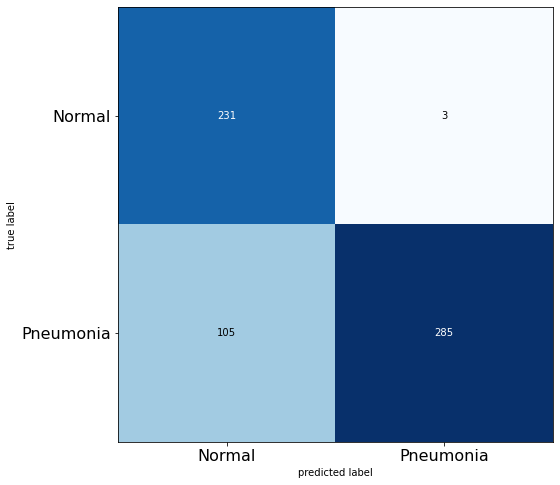

In [16]:
prediction_report("../input/resnet101-balanced/pneumonia_resnet101_balanced.h5", test_generator, test_samples=624 , batch_size = 16 )

on our data

Prediction in probability:
[[0.5194237  0.48057625]
 [0.4927784  0.50722164]
 [0.5098709  0.49012914]
 [0.517235   0.48276505]
 [0.502742   0.49725804]
 [0.48967385 0.5103262 ]
 [0.49460793 0.5053921 ]
 [0.5249669  0.4750331 ]
 [0.5190055  0.48099452]
 [0.51960695 0.48039308]
 [0.49476448 0.5052355 ]
 [0.53155005 0.46844992]
 [0.4853585  0.5146415 ]
 [0.5099923  0.4900077 ]
 [0.5158703  0.4841297 ]
 [0.4807366  0.5192633 ]
 [0.50253963 0.49746034]
 [0.48719597 0.51280403]
 [0.47651127 0.52348876]
 [0.45825303 0.541747  ]
 [0.49338168 0.5066184 ]
 [0.5187618  0.48123822]
 [0.52183574 0.4781642 ]
 [0.49510393 0.5048961 ]
 [0.4969124  0.5030876 ]
 [0.5065089  0.4934911 ]
 [0.5149976  0.48500243]
 [0.49845046 0.50154954]
 [0.49712422 0.5028758 ]
 [0.5011601  0.4988399 ]
 [0.50477266 0.4952273 ]
 [0.5070968  0.49290314]
 [0.51694643 0.48305357]
 [0.52502006 0.47497997]
 [0.48604947 0.5139505 ]
 [0.49861687 0.5013831 ]
 [0.5230448  0.47695518]
 [0.51234853 0.48765144]
 [0.5251769  0.47482312

<Figure size 432x288 with 0 Axes>

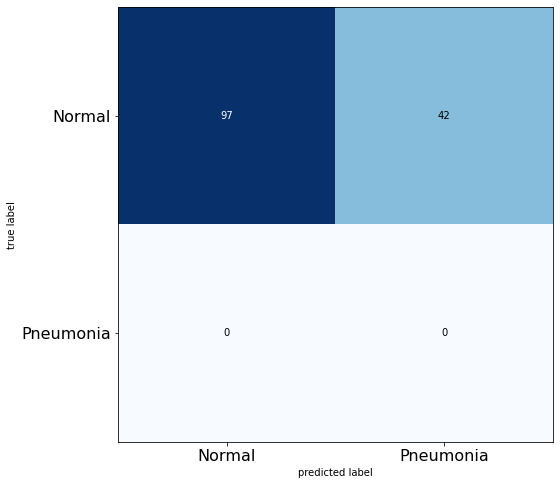

In [17]:
prediction_report("../input/resnet101-balanced/pneumonia_resnet101_balanced.h5", test_generator2, test_samples=139 , batch_size = 1 )

class probability of each image around 50%

Resnet attention after handling class imbalance 

on kaggle data

Prediction in probability:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Prediction in class:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

<Figure size 432x288 with 0 Axes>

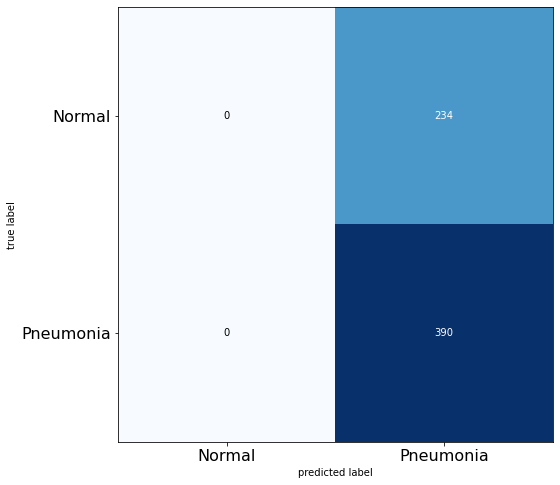

In [12]:

prediction_report("../input/residual-att-balanced/resAtt_mod_balance.h5", test_generator, test_samples=624 , batch_size = 16 )

on our data

Prediction in probability:
[[1.06261275e-21 1.00000000e+00]
 [1.08231397e-08 1.00000000e+00]
 [4.22172922e-11 1.00000000e+00]
 [8.98955405e-01 1.01044610e-01]
 [4.66569902e-22 1.00000000e+00]
 [1.87775731e-01 8.12224209e-01]
 [4.62085809e-05 9.99953747e-01]
 [6.92812382e-22 1.00000000e+00]
 [2.28884016e-22 1.00000000e+00]
 [3.85051019e-11 1.00000000e+00]
 [4.61283103e-02 9.53871667e-01]
 [5.75120449e-02 9.42487895e-01]
 [1.48103863e-04 9.99851823e-01]
 [3.54113337e-03 9.96458828e-01]
 [4.63678381e-27 1.00000000e+00]
 [1.42083466e-02 9.85791683e-01]
 [5.76521095e-04 9.99423504e-01]
 [1.54594932e-08 1.00000000e+00]
 [1.82354088e-12 1.00000000e+00]
 [1.63079890e-13 1.00000000e+00]
 [5.17720719e-12 1.00000000e+00]
 [2.72897308e-15 1.00000000e+00]
 [7.05163467e-13 1.00000000e+00]
 [6.13696393e-05 9.99938607e-01]
 [5.46027382e-04 9.99453962e-01]
 [3.34345236e-06 9.99996662e-01]
 [9.51200491e-06 9.99990463e-01]
 [9.83334482e-01 1.66655555e-02]
 [6.03723183e-10 1.00000000e+00]
 [4.23137732e-23

<Figure size 432x288 with 0 Axes>

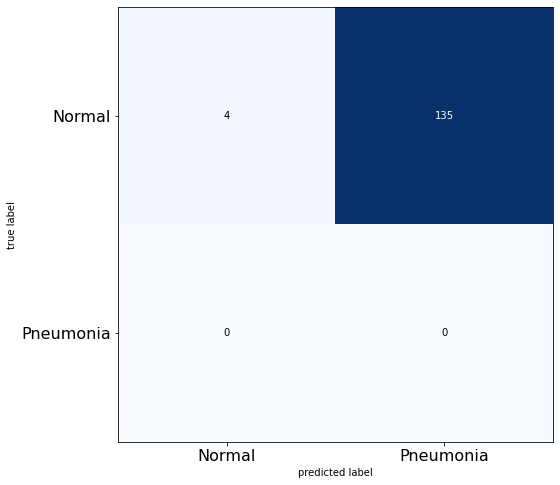

In [18]:
prediction_report("../input/residual-att-balanced/resAtt_mod_balance.h5", test_generator2, test_samples=139 , batch_size = 1 )

Using resnet attention model without handling class imbalance

on our data

Prediction in probability:
[[5.14533720e-04 9.99485493e-01]
 [9.58766032e-06 9.99990463e-01]
 [3.12247403e-06 9.99996901e-01]
 [9.94823694e-01 5.17627876e-03]
 [9.99999881e-01 1.58832350e-07]
 [9.94184434e-01 5.81561867e-03]
 [8.85213137e-01 1.14786848e-01]
 [1.10360179e-06 9.99998927e-01]
 [5.66751480e-01 4.33248490e-01]
 [2.19355258e-07 9.99999762e-01]
 [9.99614477e-01 3.85474821e-04]
 [2.76119239e-03 9.97238755e-01]
 [4.88353595e-02 9.51164603e-01]
 [2.33435840e-03 9.97665644e-01]
 [9.99991298e-01 8.65711081e-06]
 [1.48884626e-02 9.85111535e-01]
 [4.06438176e-07 9.99999642e-01]
 [9.99979854e-01 2.01997864e-05]
 [6.00241692e-05 9.99939919e-01]
 [9.92590785e-01 7.40922894e-03]
 [4.68322545e-01 5.31677425e-01]
 [1.94133536e-04 9.99805868e-01]
 [8.39113223e-09 1.00000000e+00]
 [6.45558164e-03 9.93544459e-01]
 [9.93247151e-01 6.75277831e-03]
 [1.63263452e-04 9.99836683e-01]
 [9.99048889e-01 9.51051130e-04]
 [9.99999166e-01 8.42992335e-07]
 [1.70175813e-03 9.98298228e-01]
 [9.95612741e-01

<Figure size 432x288 with 0 Axes>

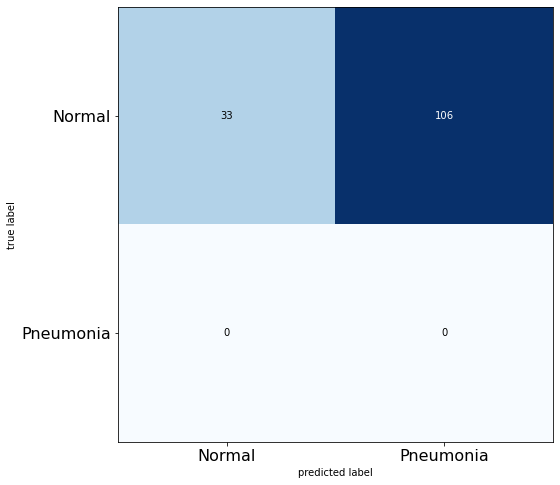

In [36]:
prediction_report("../input/residual-attention/resAtt_mod.h5", test_generator2, test_samples=139 , batch_size = 1 )